<a href="https://colab.research.google.com/github/Narenderreddyranabothu/DataScience-Project/blob/main/P_and_O_of_smart_grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files

# This will open a file picker dialog
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption (1).txt


In [8]:
# Importing necessary libraries
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For prettier graphs
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.ensemble import RandomForestRegressor  # For building a prediction model
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For evaluating the model
from datetime import datetime  # For handling dates
from sklearn.preprocessing import StandardScaler  # For scaling data
import statsmodels.api as sm  # For statistical analysis (optional)


In [9]:
# Load the dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)

# Check all column names to ensure 'Date' column exists and its exact name
print("Column names in the dataset:")
print(df.columns)

# Clean column names (remove leading/trailing spaces or unexpected characters)
df.columns = df.columns.str.strip()

# Check again if the 'Date' column exists
if 'Date' in df.columns:
    print("Initial DataFrame (First few rows):")
    print(df.head())
else:
    print("'Date' column is missing or named differently. Please verify the column name.")

# Preprocessing steps
# Convert 'Date' and 'Time' columns to datetime format
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Handle missing values (replace '?' with NaN, then fill with median)
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(df.median(), inplace=True)

# Feature engineering (creating lag features)
df['Global_active_power_lag1'] = df['Global_active_power'].shift(1)
df['Global_active_power_lag24'] = df['Global_active_power'].shift(24)

# Drop rows with NaN values due to the lag
df = df.dropna()

# Define features (X) and target variable (y)
X = df[['Global_active_power_lag1', 'Global_active_power_lag24']]
y = df['Global_active_power']

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (important for models like ANN, SVM, k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Column names in the dataset:
Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')
Initial DataFrame (First few rows):
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3    

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# --- Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)  # Train the model

# Predict the energy consumption for the test set
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model's performance (Mean Squared Error)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print(f"Linear Regression - Mean Squared Error: {mse_lr}")
print(f"Linear Regression - Root Mean Squared Error: {rmse_lr}")



Linear Regression - Mean Squared Error: 0.0684663620577772
Linear Regression - Root Mean Squared Error: 0.2616607766895474


In [12]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")



Mean Squared Error: 0.085398155956727
Root Mean Squared Error: 0.2922296288139295


In [13]:
from sklearn.neural_network import MLPRegressor
# --- Artificial Neural Network (ANN) ---
ann_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
ann_model.fit(X_train_scaled, y_train)
y_pred_ann = ann_model.predict(X_test_scaled)
mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)

print(f"ANN Model - MSE: {mse_ann}, RMSE: {rmse_ann}")

import matplotlib.pyplot as plt



ANN Model - MSE: 0.06801800442986153, RMSE: 0.26080261584167735


In [14]:
# Importing necessary libraries for Gradient Boosting and XGBoost
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# --- Gradient Boosting Model ---
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)

print(f"Gradient Boosting Model - MSE: {mse_gb}, RMSE: {rmse_gb}")



Gradient Boosting Model - MSE: 0.06787469400230908, RMSE: 0.26052772213779685


<ipython-input-15-2037649441>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_values, palette='viridis')


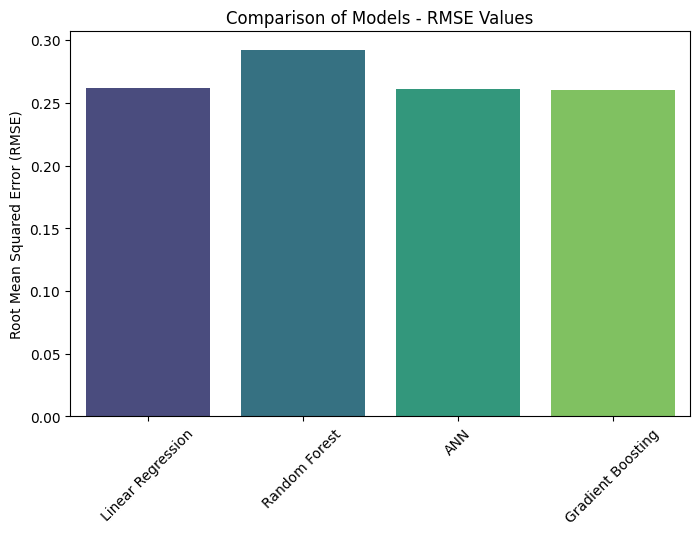

In [15]:
# Compare all model performances
models = ['Linear Regression', 'Random Forest', 'ANN', 'Gradient Boosting']
rmse_values = [rmse_lr, rmse, rmse_ann, rmse_gb]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=rmse_values, palette='viridis')
plt.title('Comparison of Models - RMSE Values')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(rotation=45)
plt.show()
